In [1]:
import pyopenms as oms
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
%matplotlib widget

In [2]:
exp = oms.MSExperiment()
oms.MzMLFile().load("../test_mzml/231004_TestAB_1.mzML", exp)

exp.sortSpectra(True)

mass_traces = []
mtd = oms.MassTraceDetection()
mtd_params = mtd.getDefaults()
mtd_params.setValue(
    "mass_error_ppm", 10.0
)  # set according to your instrument mass error
mtd_params.setValue(
    "noise_threshold_int", 100000.0
)  # adjust to noise level in your data
mtd.setParameters(mtd_params)
mtd.run(exp, mass_traces, 0)

mass_traces_split = []
mass_traces_final = []
epd = oms.ElutionPeakDetection()
epd_params = epd.getDefaults()
epd_params.setValue("width_filtering", "fixed")
epd.setParameters(epd_params)
epd.detectPeaks(mass_traces, mass_traces_split)

if epd.getParameters().getValue("width_filtering") == "auto":
    epd.filterByPeakWidth(mass_traces_split, mass_traces_final)
else:
    mass_traces_final = mass_traces_split

fm = oms.FeatureMap()
feat_chrom = []
ffm = oms.FeatureFindingMetabo()
ffm_params = ffm.getDefaults()
ffm_params.setValue("isotope_filtering_model", "none")
ffm_params.setValue(
    "remove_single_traces", "true"
)  # set false to keep features with only one mass trace
ffm_params.setValue("mz_scoring_by_elements", "false")
ffm_params.setValue("report_convex_hulls", "true")
ffm.setParameters(ffm_params)
ffm.run(mass_traces_final, fm, feat_chrom)

fm.setUniqueIds()
fm.setPrimaryMSRunPath(["test_mzml/example1.mzML".encode()])
ft=fm.get_df()
ft

Progress of 'mass trace detection':
-- done [took 6.64 s (CPU), 7.10 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.16 s (CPU), 0.02 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 0.15 s (CPU), 0.02 s (Wall)] -- 


peptide_sequence  peptide_score ID_filename ID_native_id  \
feature_id                                                                      
15177996260158679541             None            NaN        None         None   
13121432707746630275             None            NaN        None         None   
9141820684871215937              None            NaN        None         None   
10870072475055663464             None            NaN        None         None   
9701423607496486954              None            NaN        None         None   
...                               ...            ...         ...          ...   
12331032701389331867             None            NaN        None         None   
12725073525750671377             None            NaN        None         None   
4728315924321910968              None            NaN        None         None   
17413494322073228081             None            NaN        None         None   
3349755717137276012              None            NaN        None         None   

                      charge          RT           mz     RTstart       RTend  \
feature_id                                                                      
15177996260158679541       3   67.913730   150.768212   64.942854   85.729362   
13121432707746630275       3  239.490684   155.440220  199.978920  312.449100   
9141820684871215937        3   68.554974   160.112047   63.663474   87.363738   
10870072475055663464       3  239.490684   160.112236  182.125662  313.114722   
9701423607496486954        1  133.022508   164.092734  126.841506  192.029040   
...                      ...         ...          ...         ...         ...   
12331032701389331867       1   69.675978  1059.556565   66.709224   77.889360   
12725073525750671377       1   68.554974  1063.554478   66.282102   81.485112   
4728315924321910968        1   69.675978  1163.538372   66.282102   81.485112   
17413494322073228081       1   72.994356  1181.544734   66.709224   80.624862   
3349755717137276012        1   70.840860  1199.556594   66.709224   82.290612   

                          MZstart        MZend   quality    intensity  
feature_id                                                             
15177996260158679541   150.768082   151.102859  0.000309   24854486.0  
13121432707746630275   155.439865   155.774811  0.000211   17428608.0  
9141820684871215937    160.112000   160.781265  0.001772  143574000.0  
10870072475055663464   160.112015   160.446945  0.000264   22184716.0  
9701423607496486954    164.092651   165.096222  0.000429   38557404.0  
...                           ...          ...       ...          ...  
12331032701389331867  1059.549438  1060.572266  0.000277   22765870.0  
12725073525750671377  1063.551025  1064.561523  0.000282   17117024.0  
4728315924321910968   1163.532959  1165.548340  0.000965   53050496.0  
17413494322073228081  1181.539917  1183.560425  0.000803   43189708.0  
3349755717137276012   1199.554199  1201.571045  0.001693  115362592.0  

[134 rows x 13 columns]

peak_idx     RT  norm_intensity
7           7   67.0        1.018611
178       178  238.0        0.042582

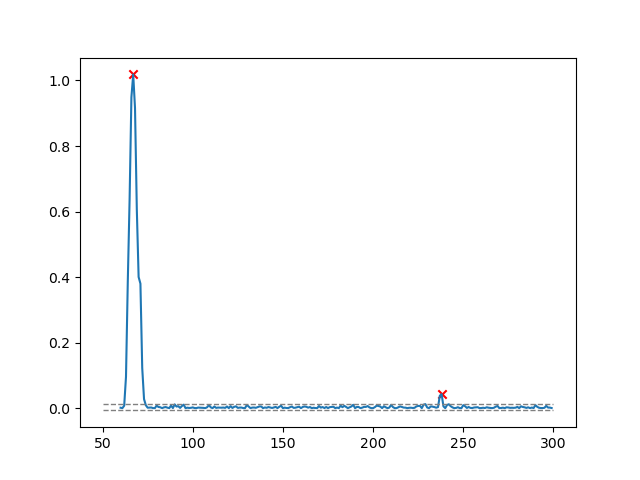

In [3]:
at=pd.read_csv("../output/merged_data_baselinecorr.csv",index_col=0)
at.sort_values("RT",inplace=True)

mn_old=at.norm_intensity.mean()
std_old=at.norm_intensity.std()

rmsd=10
while rmsd>0.02:
    test=at.loc[at.norm_intensity<mn_old+3*std_old,"norm_intensity"]
    mn_new=test.mean()
    std_new=test.std()
    
    rmsd=np.sqrt(np.mean((std_new-std_old)**2))
    
    mn_old=mn_new
    std_old=std_new

peaks,_=signal.find_peaks(at.norm_intensity,height=mn_old+3*std_old)

aft=pd.DataFrame({"peak_idx":peaks,"RT":at.loc[peaks,"RT"],"norm_intensity":at.loc[peaks,"norm_intensity"]})

fig,ax=plt.subplots()
ax.plot(at.RT,at.norm_intensity)
ax.scatter(aft.RT,aft.norm_intensity,marker="x",c="red")
ax.hlines([mn_old+3*std_old,mn_old-3*std_old],xmin=50,xmax=300,linewidth=1,colors="gray",ls="--")

aft

In [4]:
ft["activity"]=np.nan

for iat in aft.index:
    test=5>np.abs(ft["RT"]-aft.loc[iat,"RT"])
    ft.loc[test,"activity"]=aft.loc[iat,"norm_intensity"]

ft


peptide_sequence  peptide_score ID_filename ID_native_id  \
feature_id                                                                      
15177996260158679541             None            NaN        None         None   
13121432707746630275             None            NaN        None         None   
9141820684871215937              None            NaN        None         None   
10870072475055663464             None            NaN        None         None   
9701423607496486954              None            NaN        None         None   
...                               ...            ...         ...          ...   
12331032701389331867             None            NaN        None         None   
12725073525750671377             None            NaN        None         None   
4728315924321910968              None            NaN        None         None   
17413494322073228081             None            NaN        None         None   
3349755717137276012              None            NaN        None         None   

                      charge          RT           mz     RTstart       RTend  \
feature_id                                                                      
15177996260158679541       3   67.913730   150.768212   64.942854   85.729362   
13121432707746630275       3  239.490684   155.440220  199.978920  312.449100   
9141820684871215937        3   68.554974   160.112047   63.663474   87.363738   
10870072475055663464       3  239.490684   160.112236  182.125662  313.114722   
9701423607496486954        1  133.022508   164.092734  126.841506  192.029040   
...                      ...         ...          ...         ...         ...   
12331032701389331867       1   69.675978  1059.556565   66.709224   77.889360   
12725073525750671377       1   68.554974  1063.554478   66.282102   81.485112   
4728315924321910968        1   69.675978  1163.538372   66.282102   81.485112   
17413494322073228081       1   72.994356  1181.544734   66.709224   80.624862   
3349755717137276012        1   70.840860  1199.556594   66.709224   82.290612   

                          MZstart        MZend   quality    intensity  \
feature_id                                                              
15177996260158679541   150.768082   151.102859  0.000309   24854486.0   
13121432707746630275   155.439865   155.774811  0.000211   17428608.0   
9141820684871215937    160.112000   160.781265  0.001772  143574000.0   
10870072475055663464   160.112015   160.446945  0.000264   22184716.0   
9701423607496486954    164.092651   165.096222  0.000429   38557404.0   
...                           ...          ...       ...          ...   
12331032701389331867  1059.549438  1060.572266  0.000277   22765870.0   
12725073525750671377  1063.551025  1064.561523  0.000282   17117024.0   
4728315924321910968   1163.532959  1165.548340  0.000965   53050496.0   
17413494322073228081  1181.539917  1183.560425  0.000803   43189708.0   
3349755717137276012   1199.554199  1201.571045  0.001693  115362592.0   

                      activity  
feature_id                      
15177996260158679541  1.018611  
13121432707746630275  0.042582  
9141820684871215937   1.018611  
10870072475055663464  0.042582  
9701423607496486954        NaN  
...                        ...  
12331032701389331867  1.018611  
12725073525750671377  1.018611  
4728315924321910968   1.018611  
17413494322073228081       NaN  
3349755717137276012   1.018611  

[134 rows x 14 columns]

/tmp/ipykernel_44329/37579492.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots()


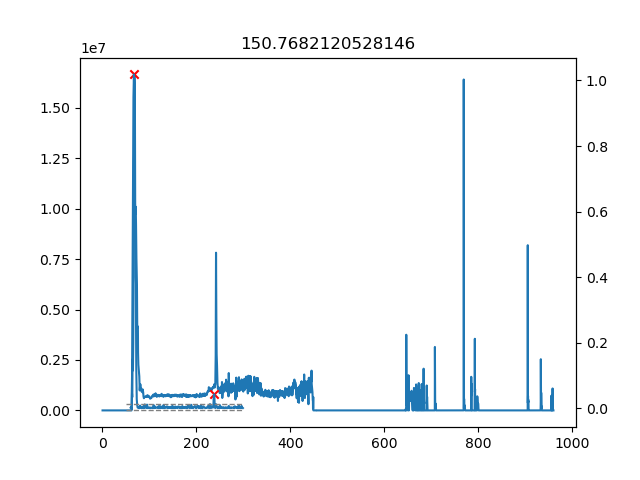

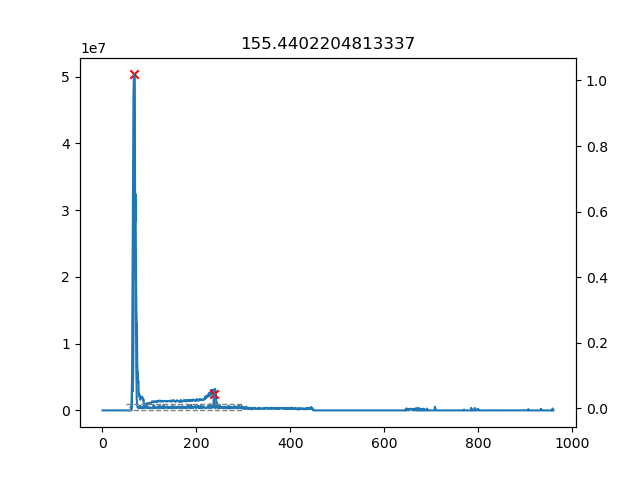

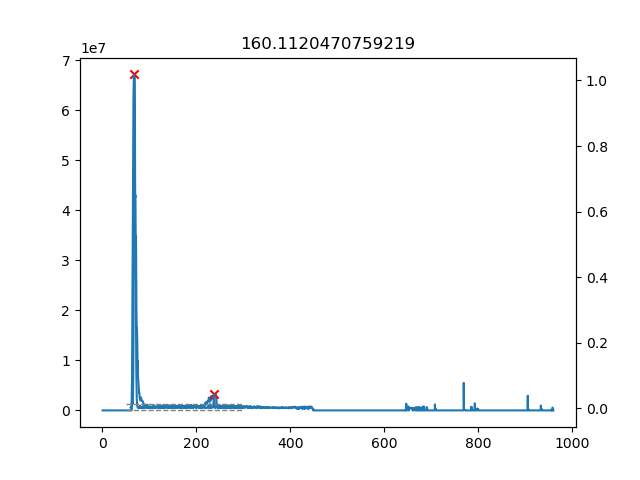

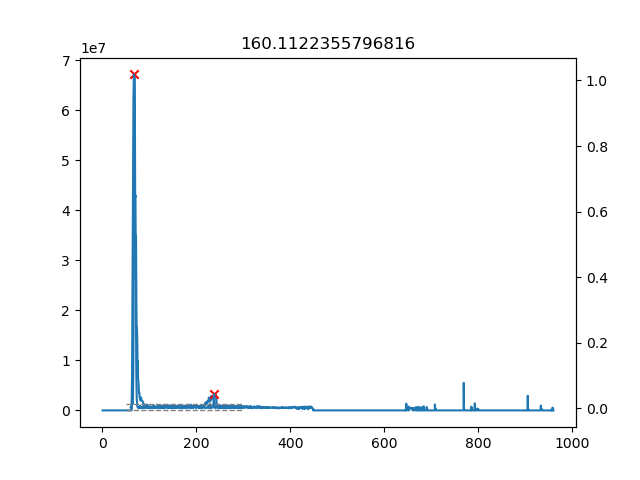

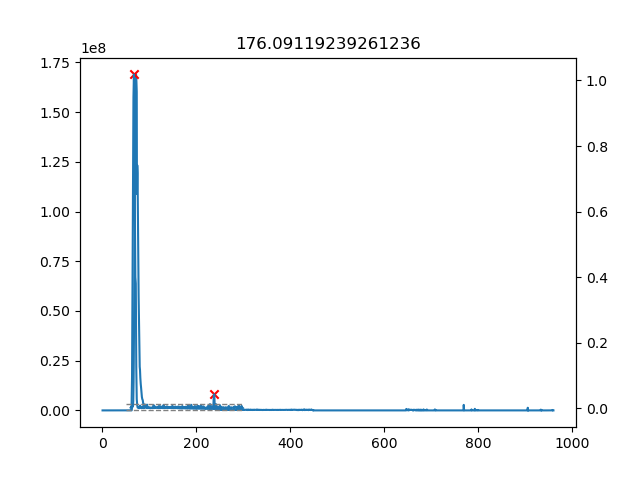

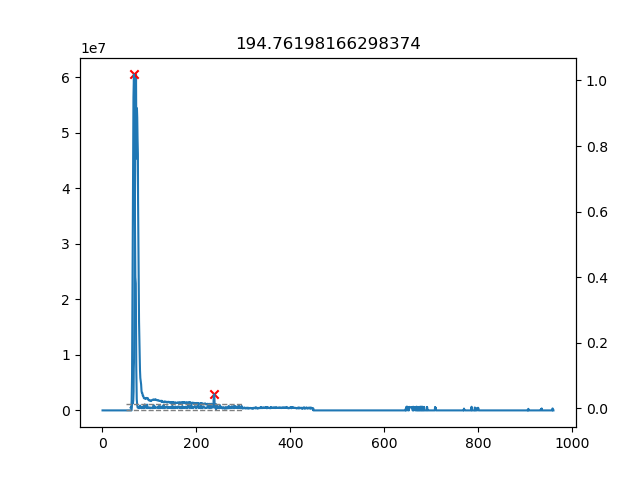

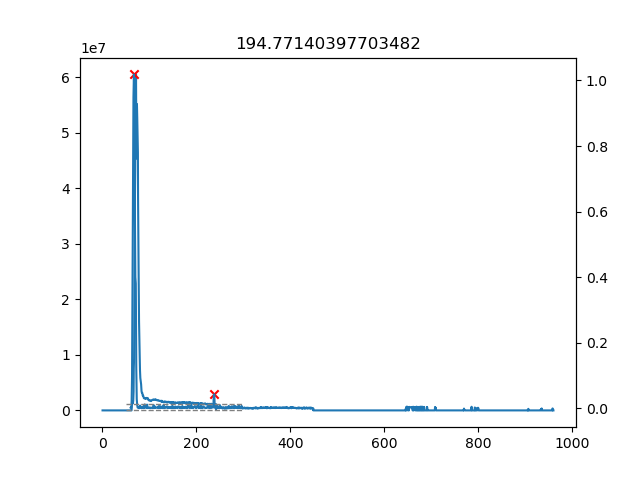

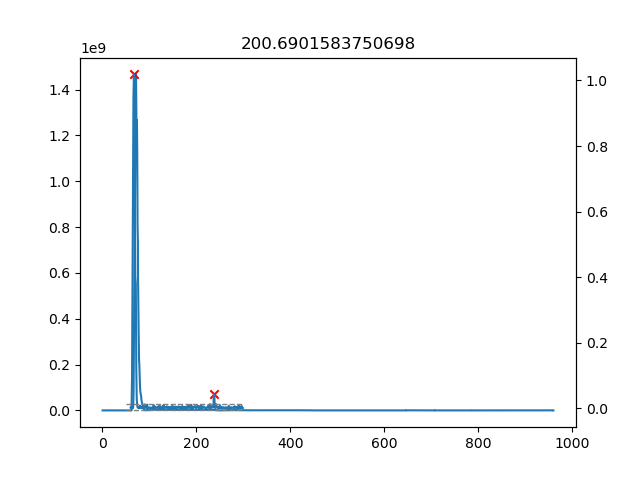

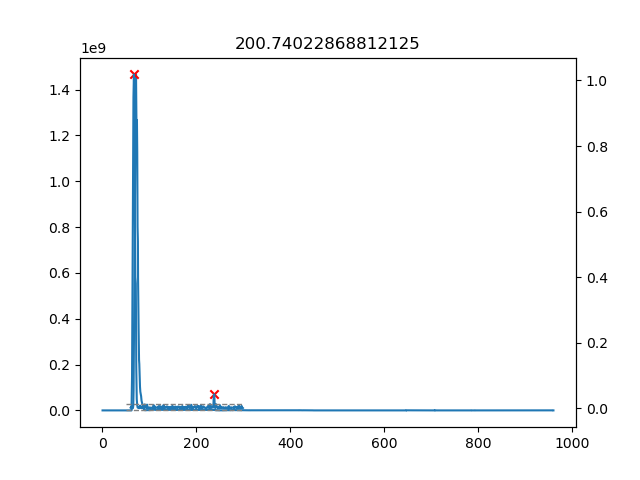

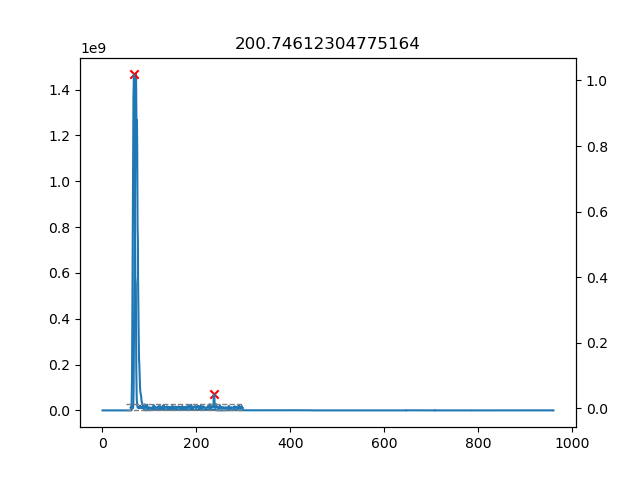

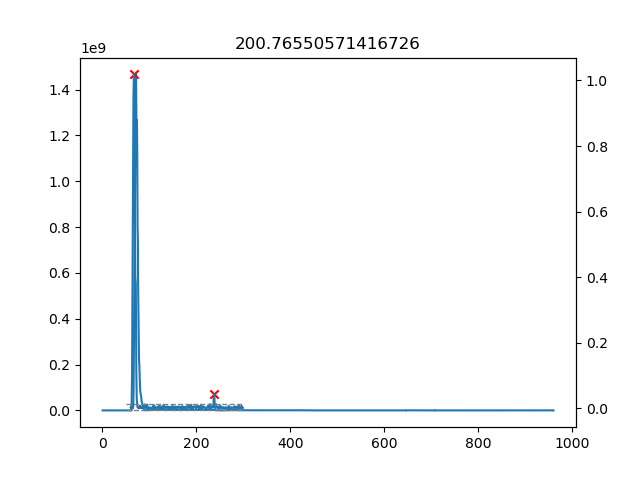

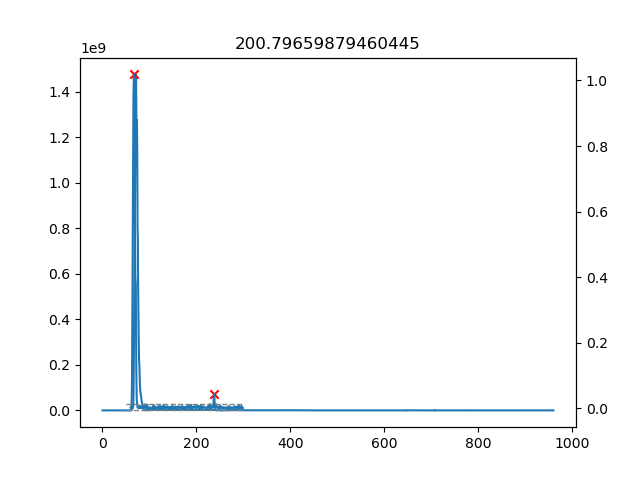

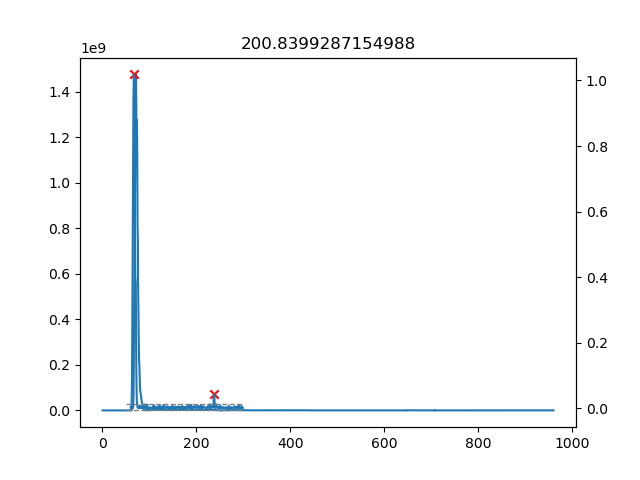

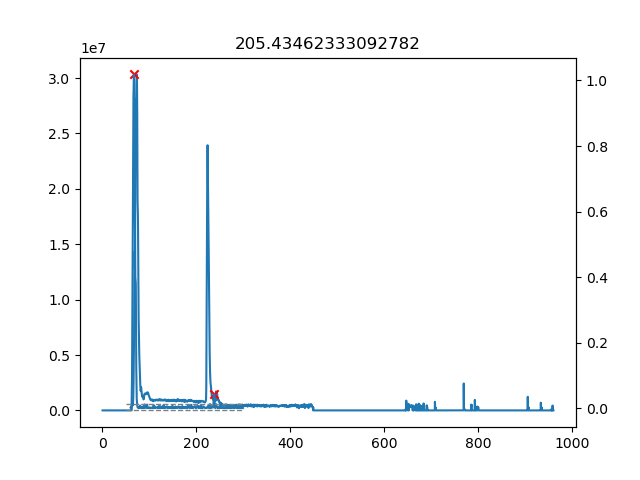

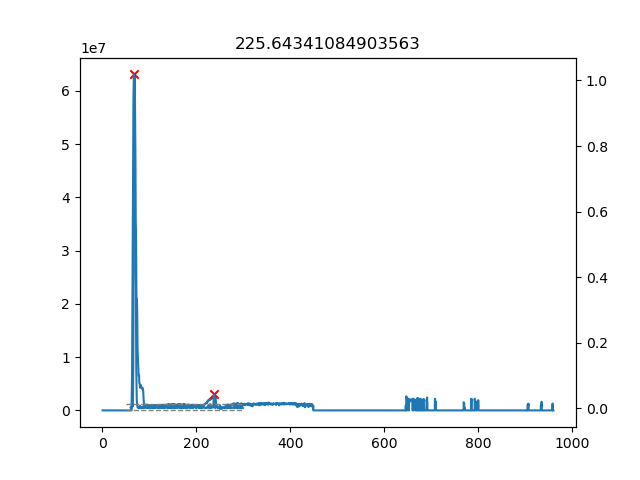

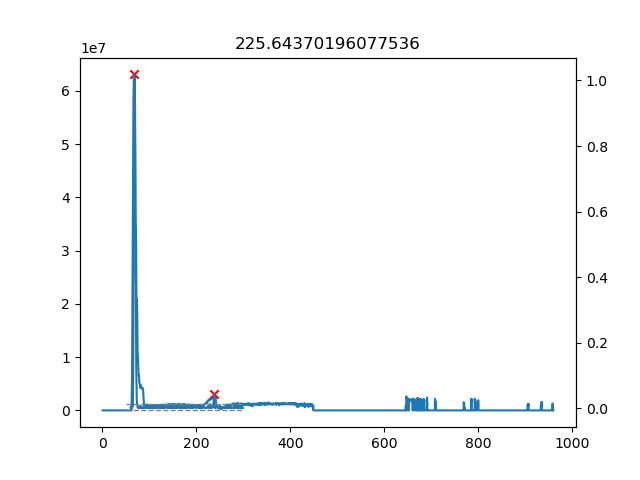

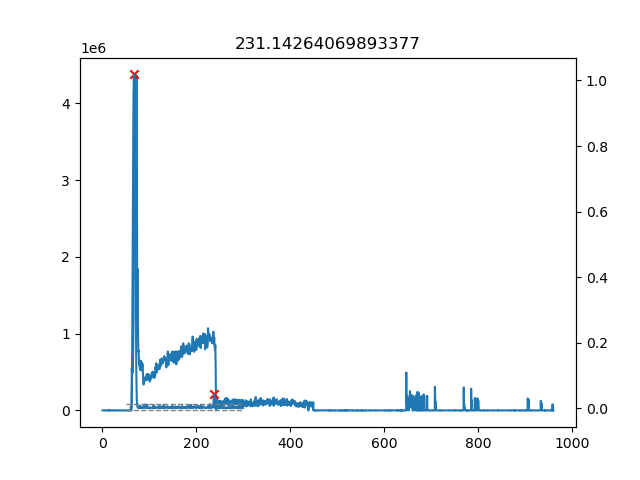

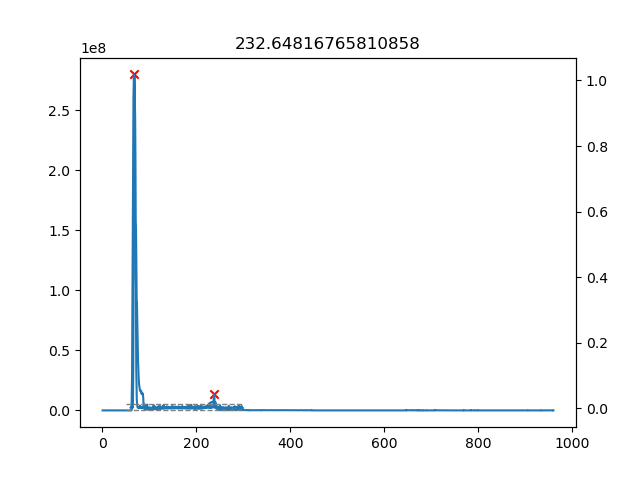

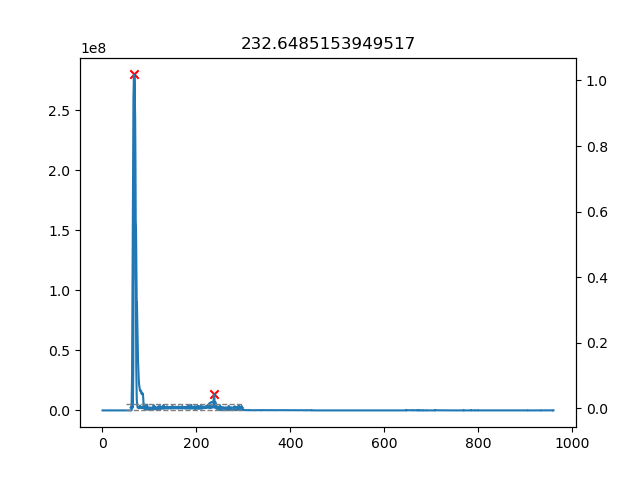

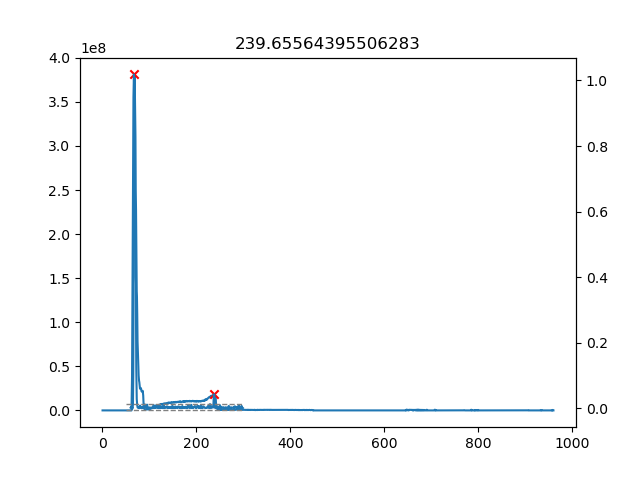

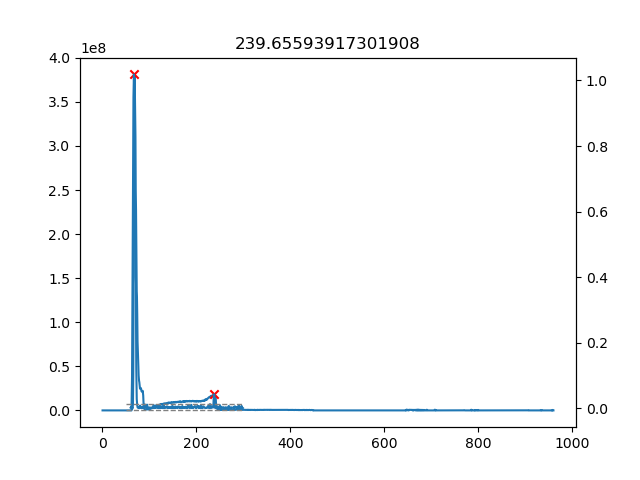

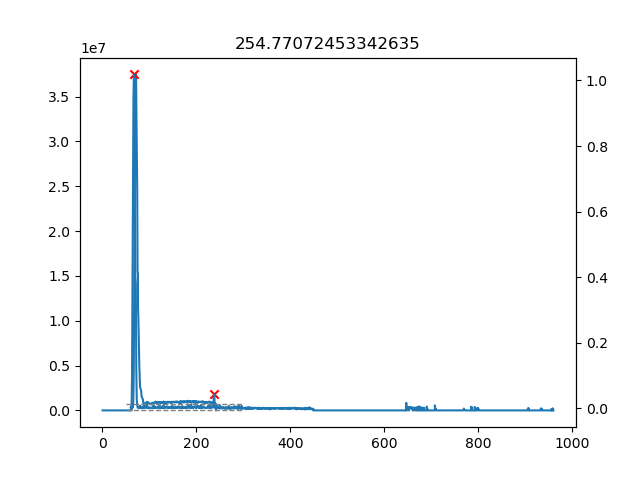

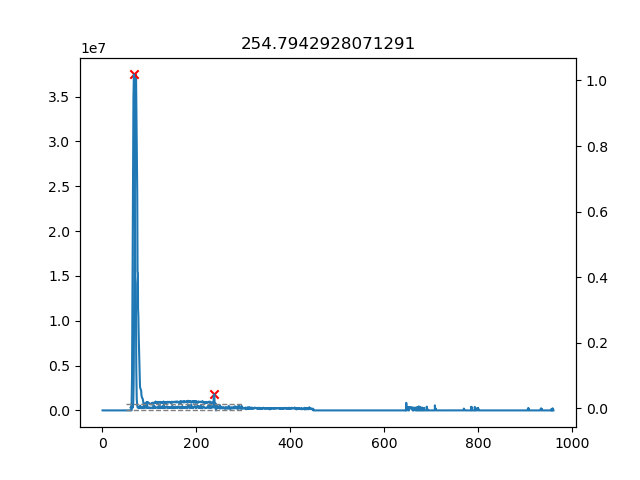

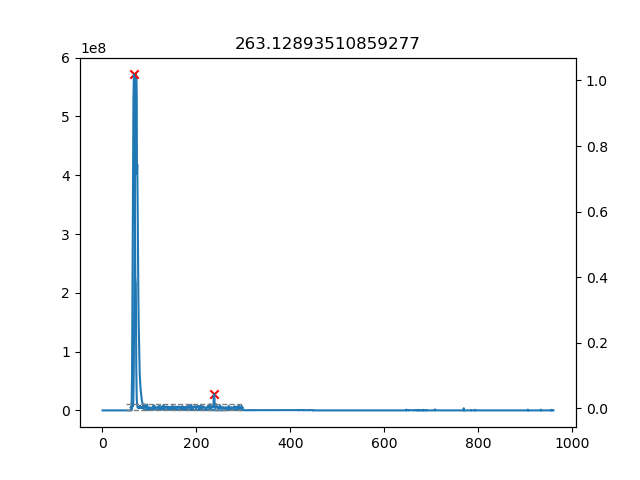

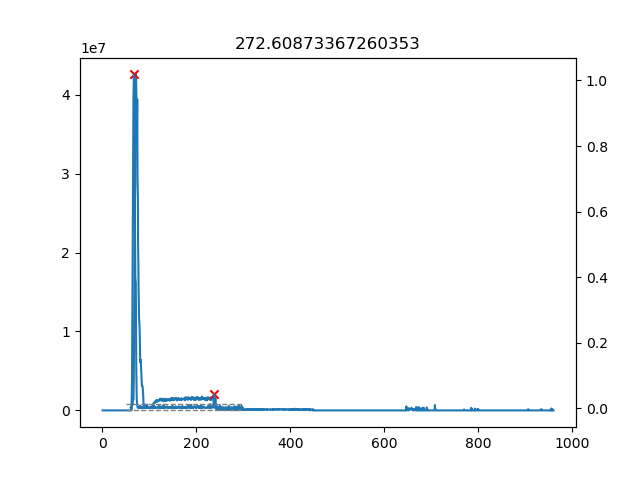

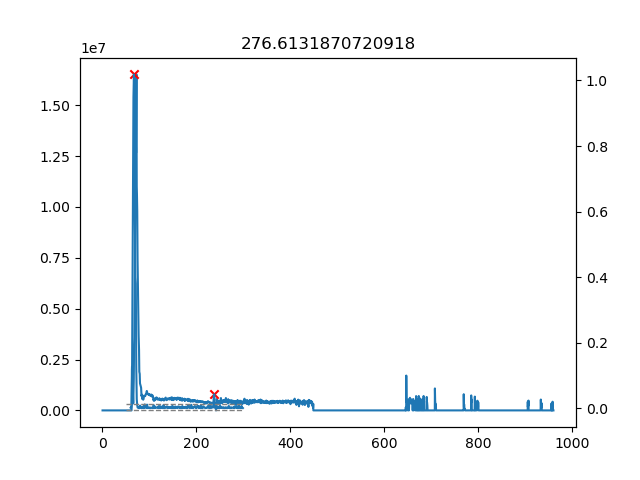

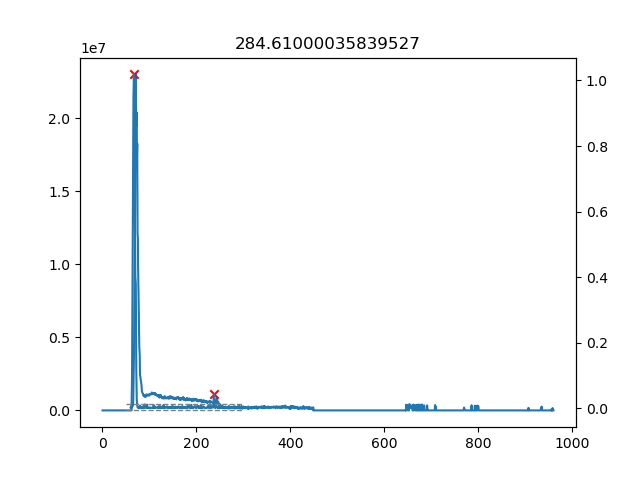

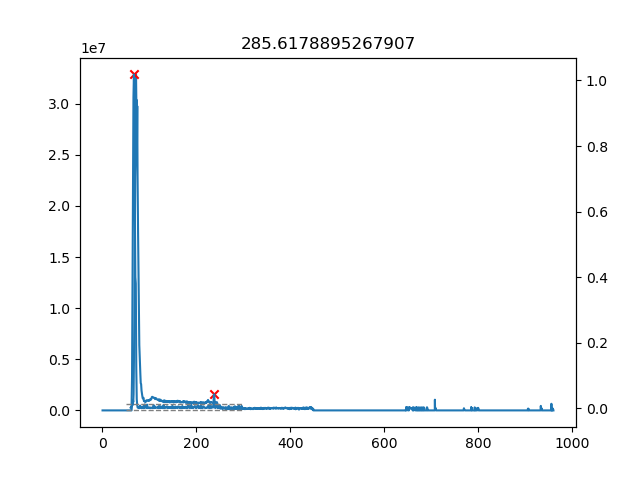

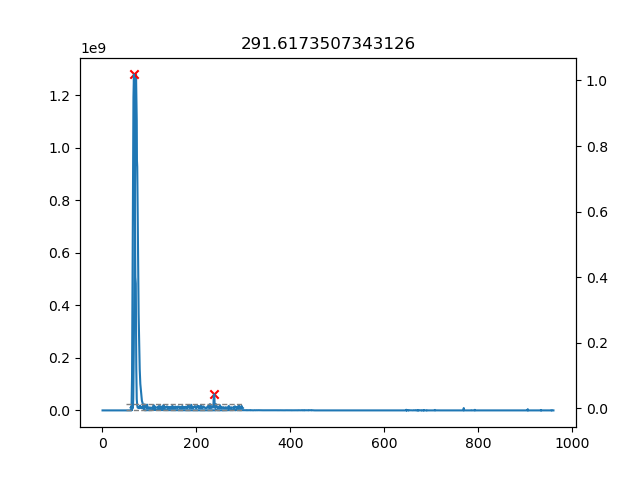

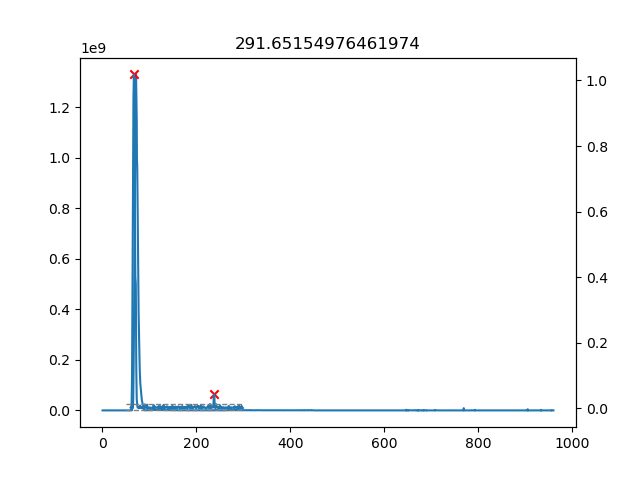

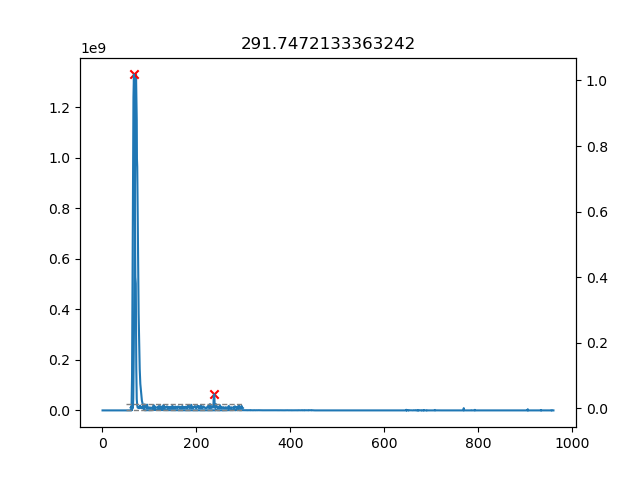

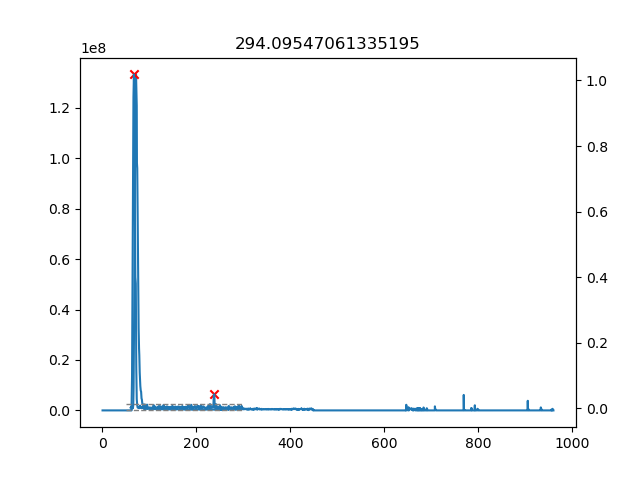

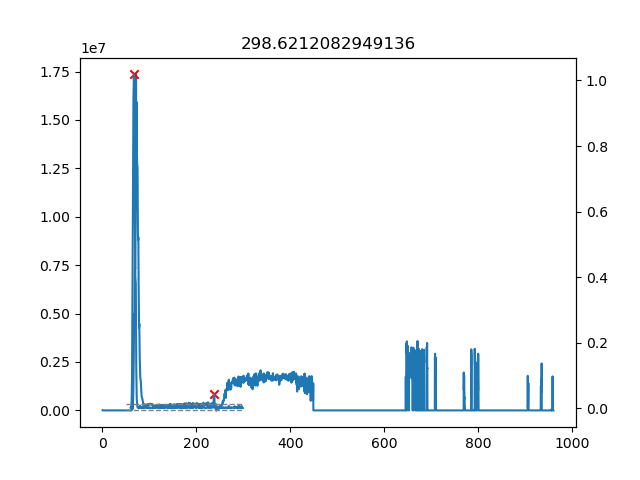

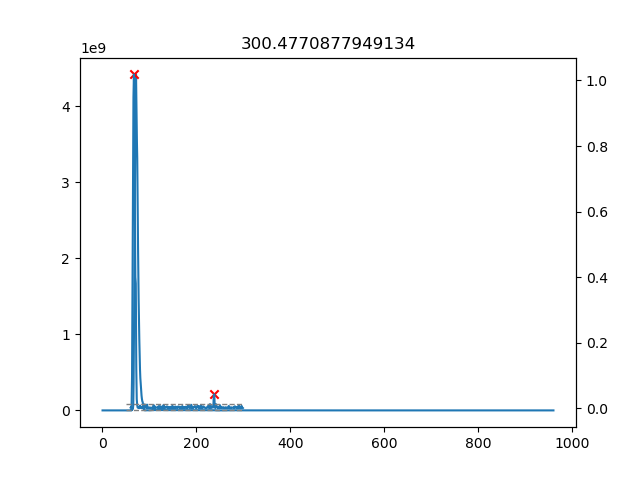

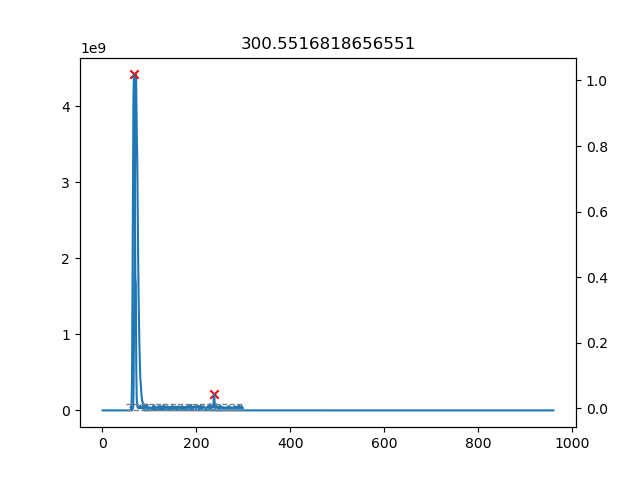

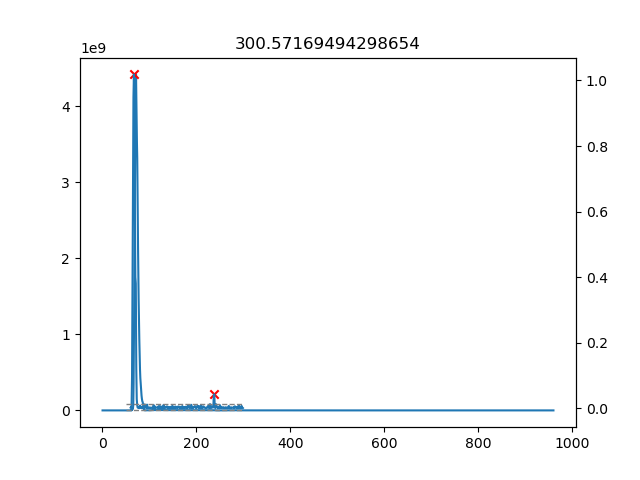

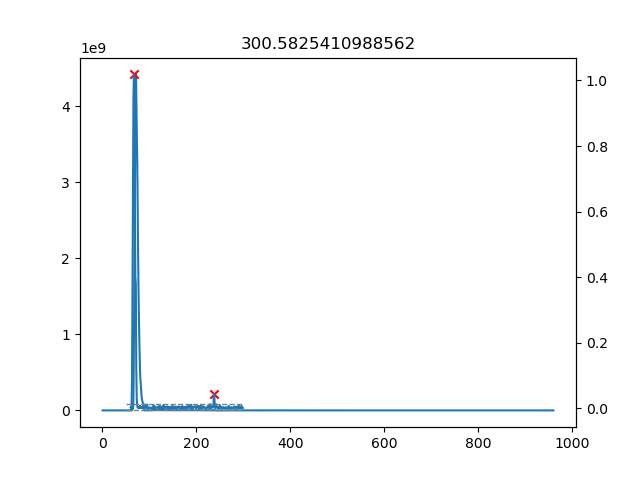

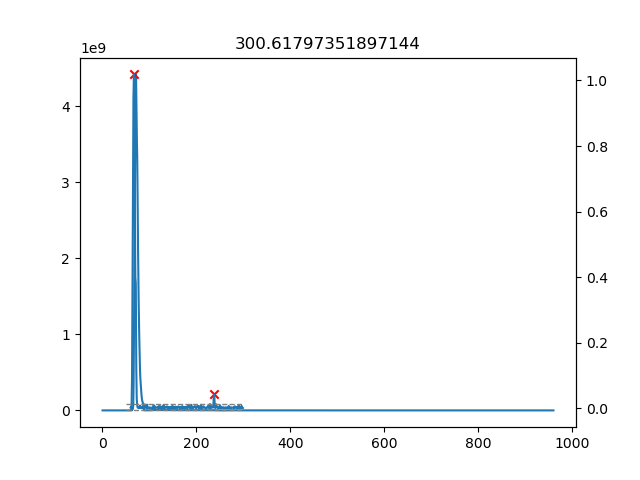

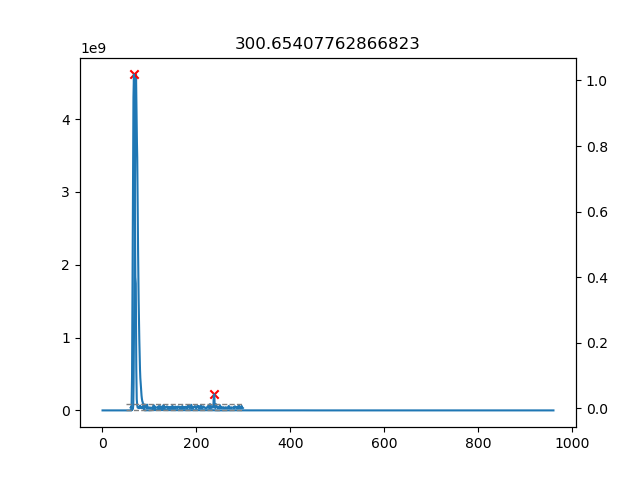

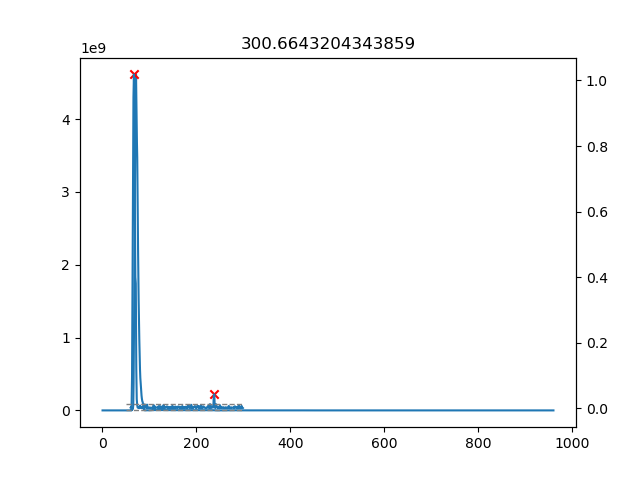

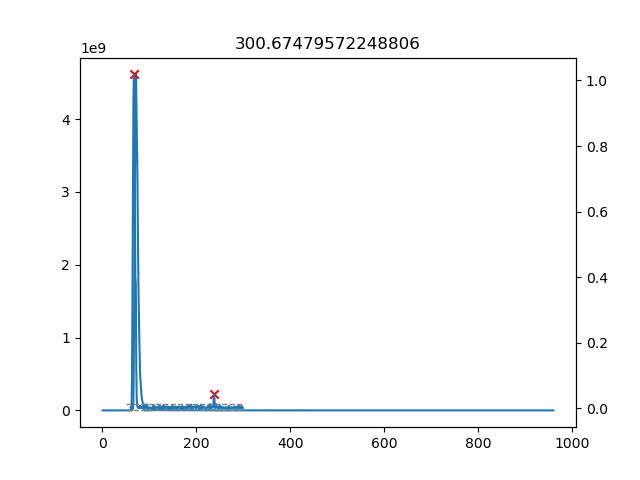

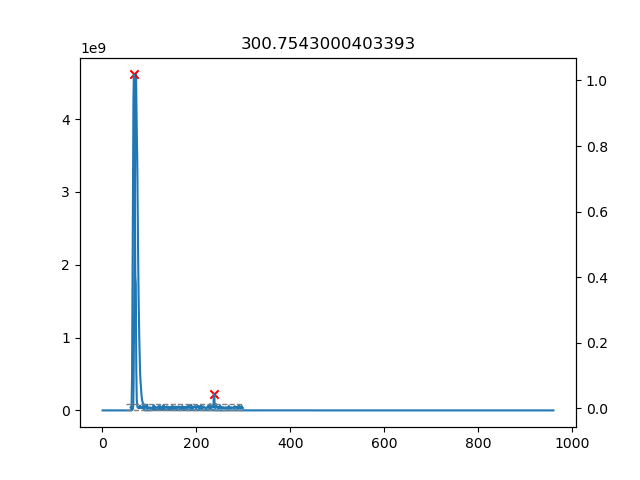

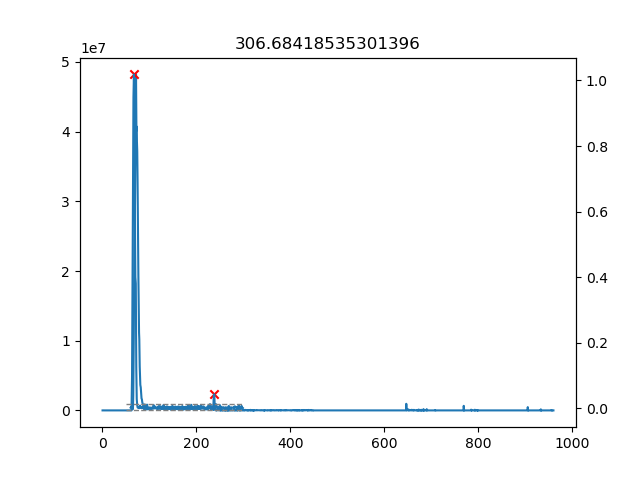

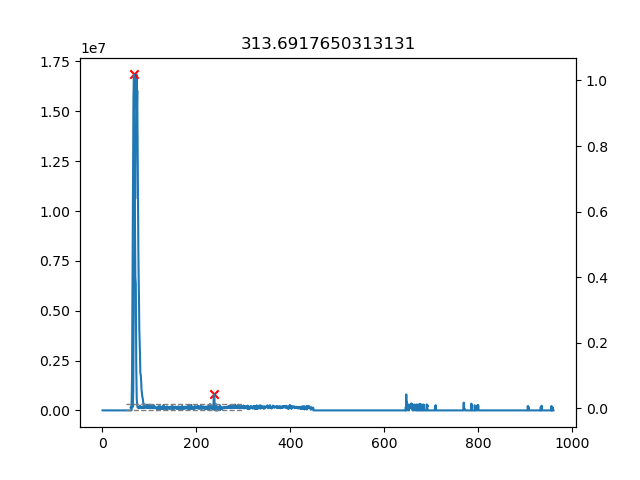

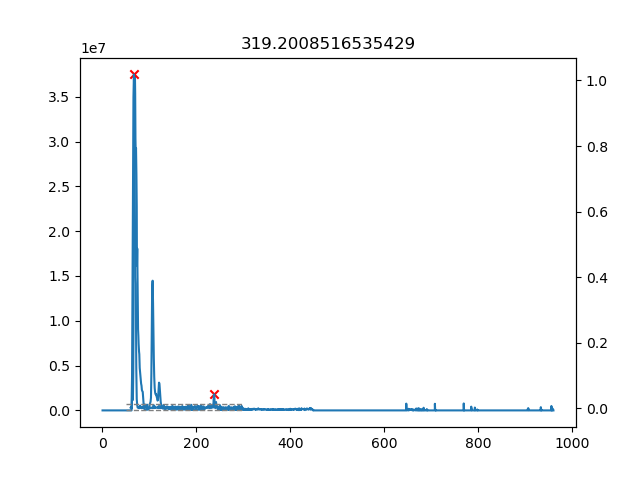

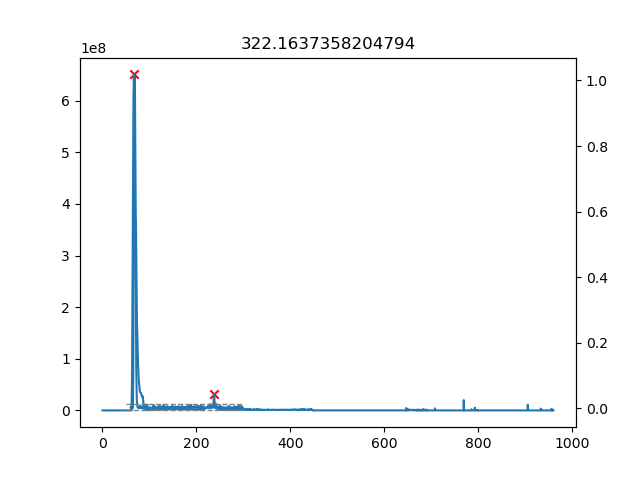

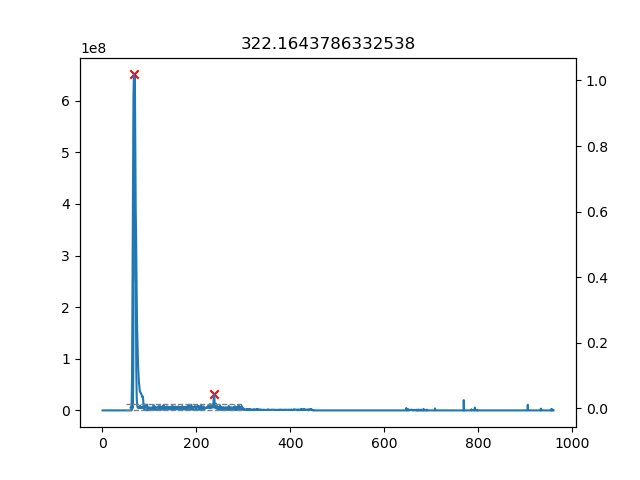

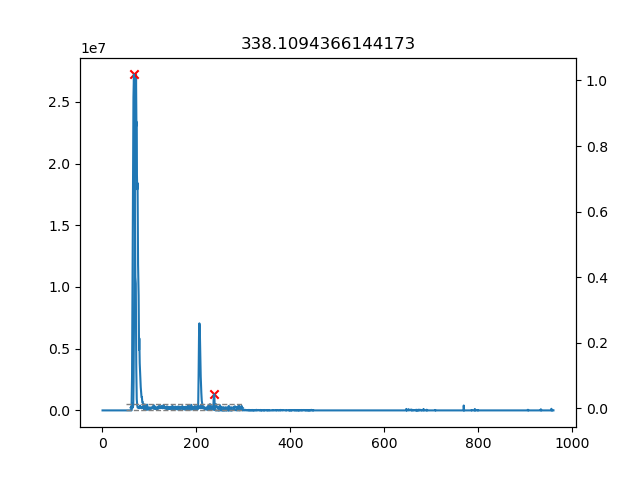

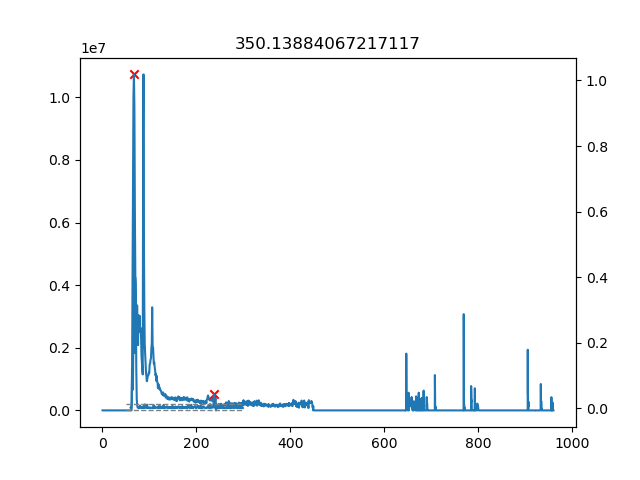

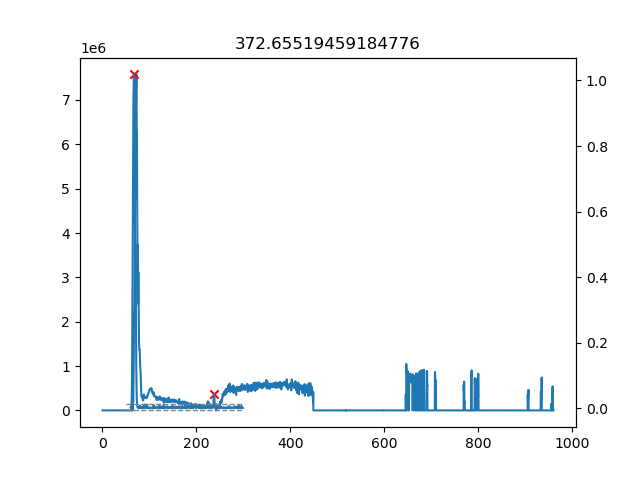

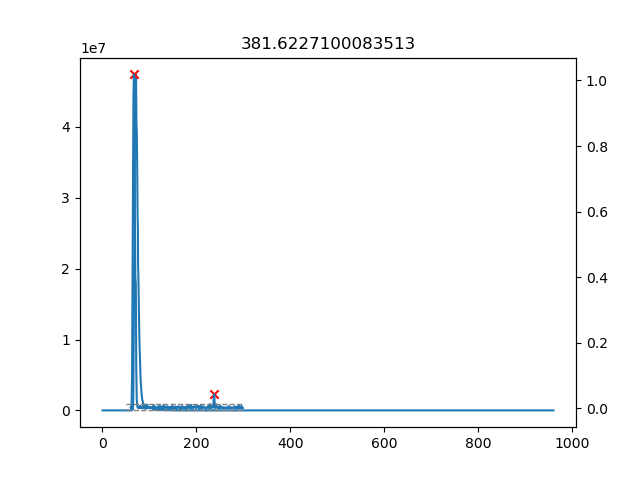

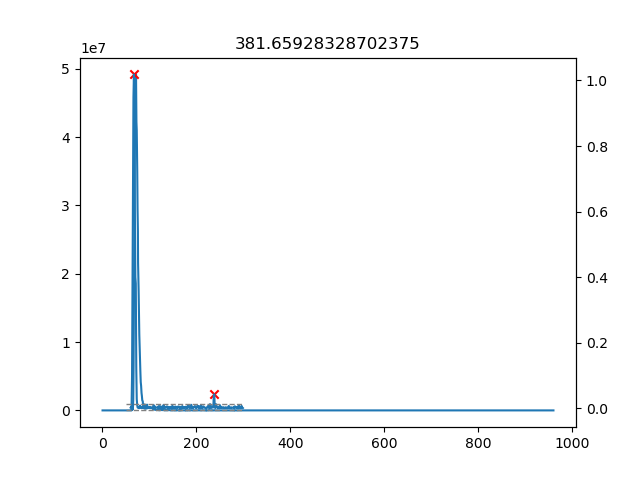

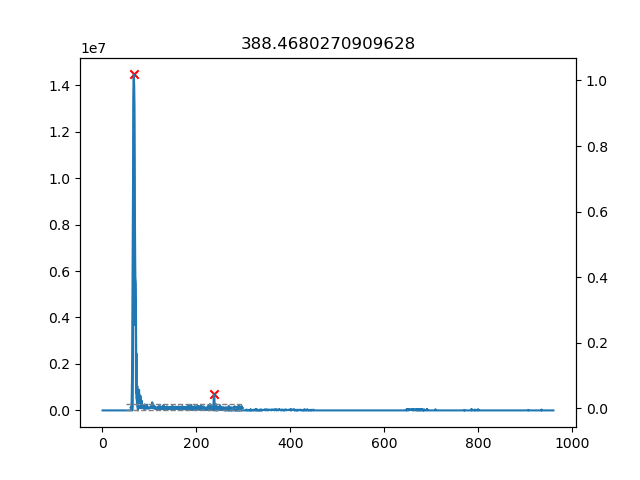

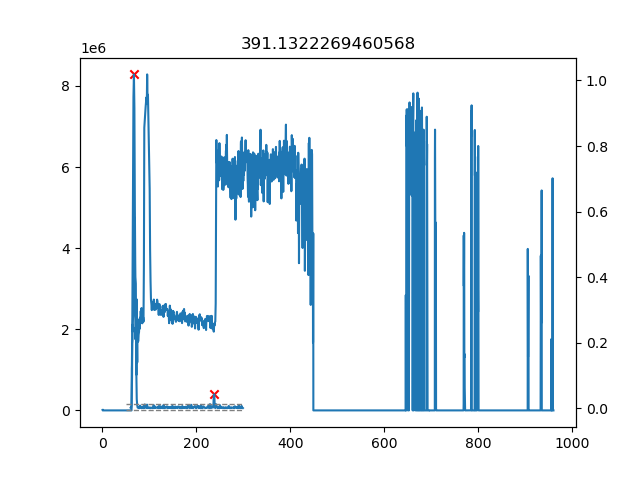

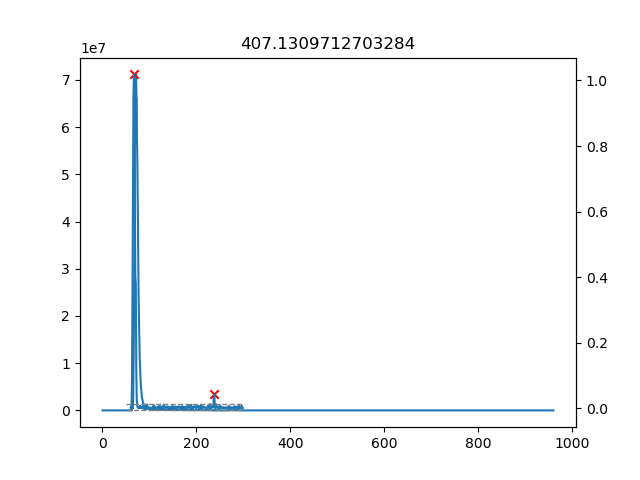

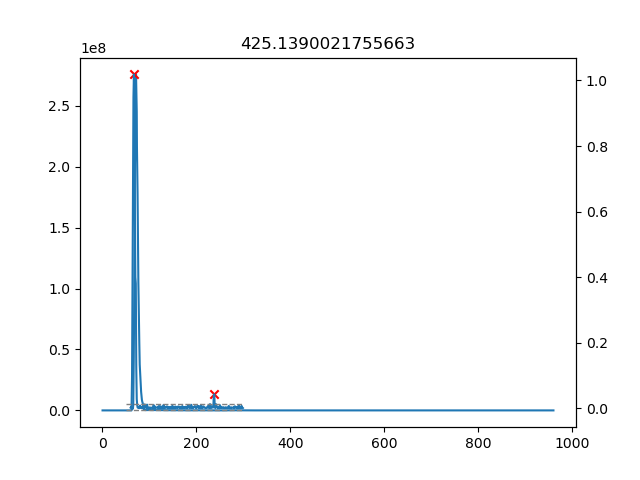

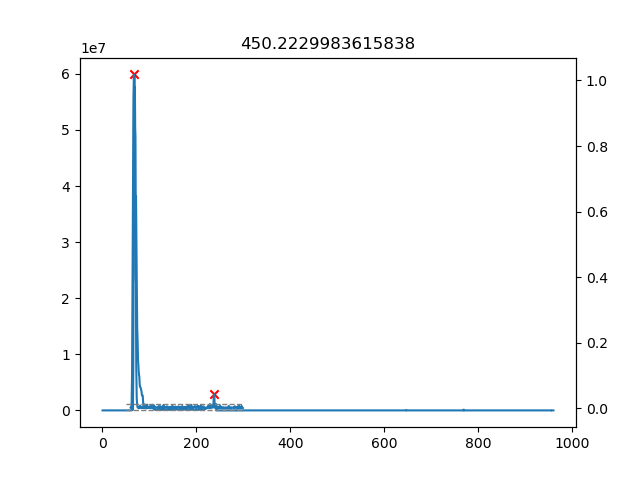

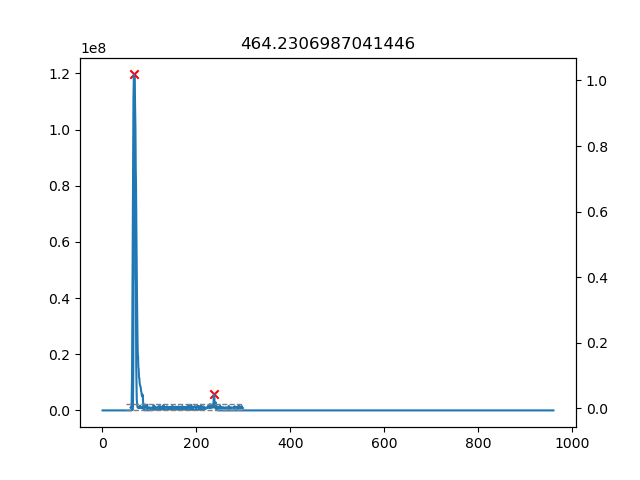

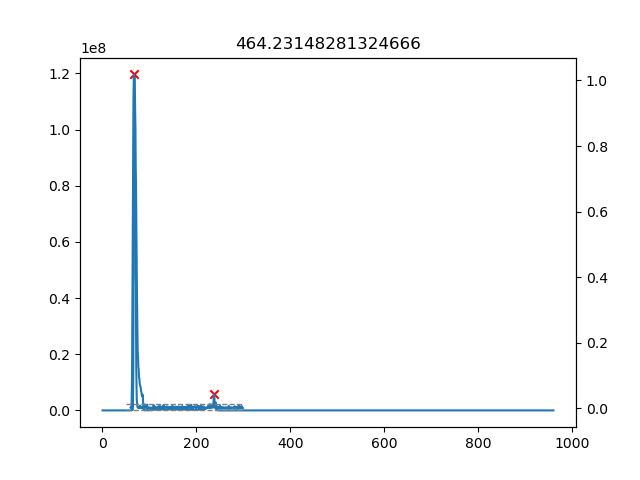

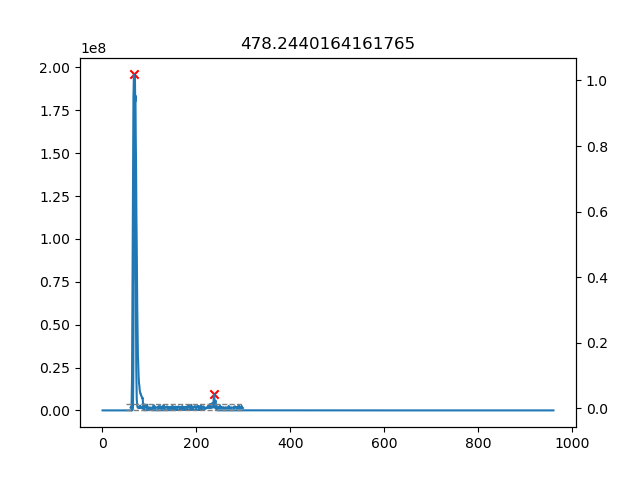

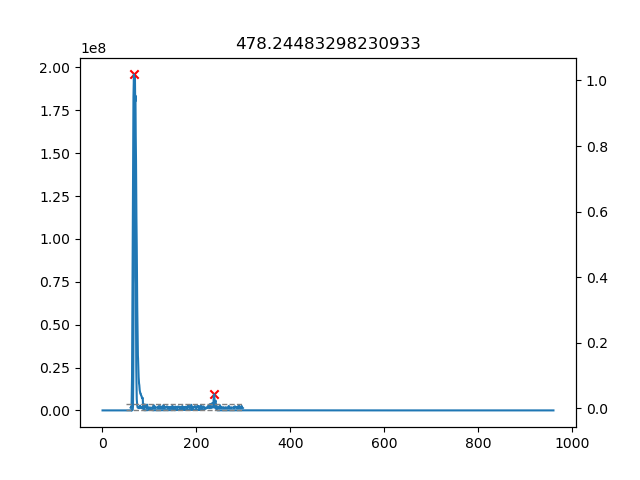

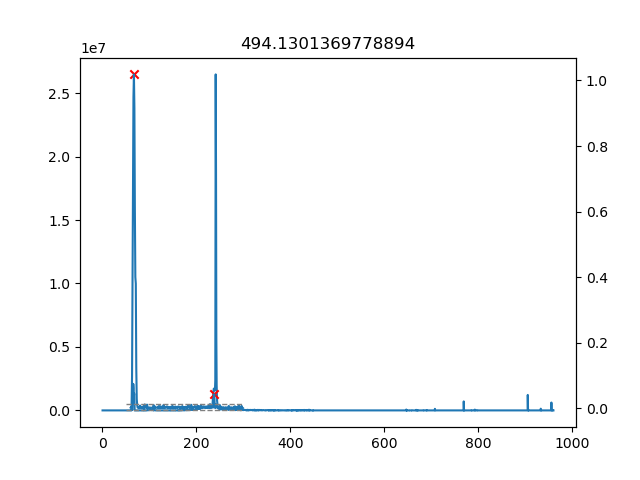

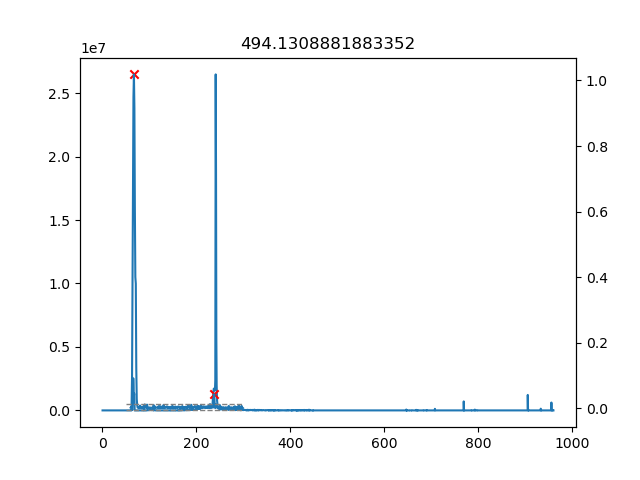

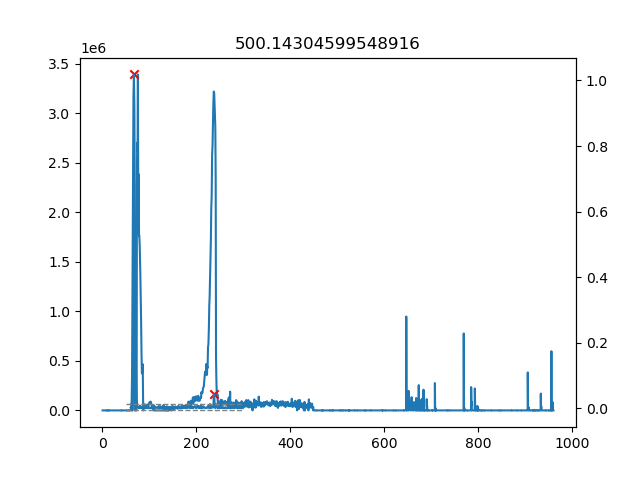

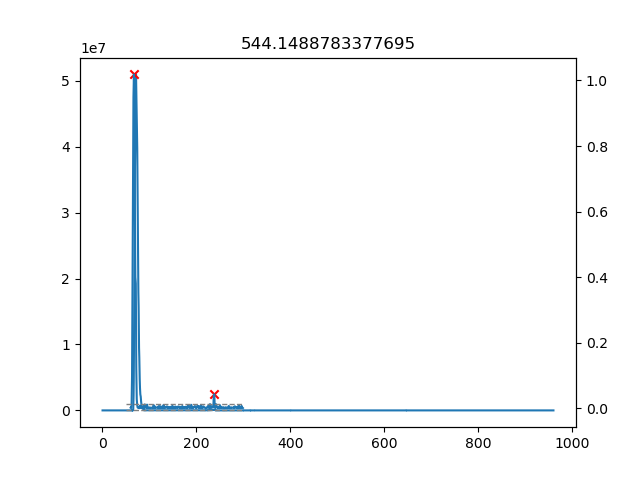

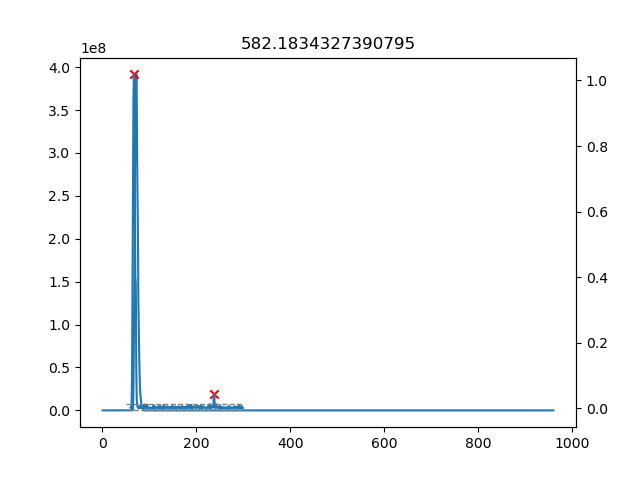

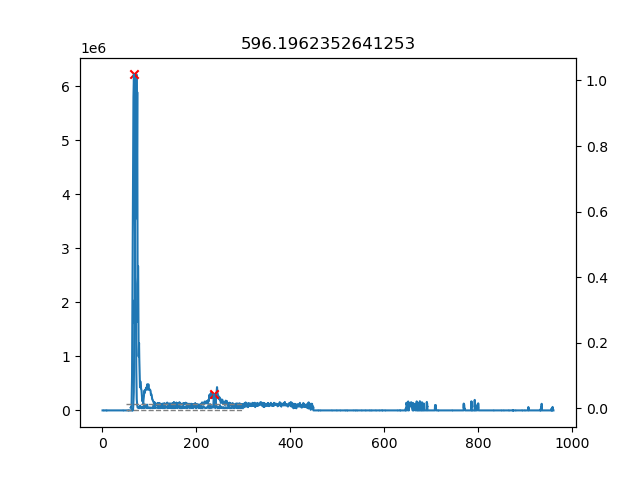

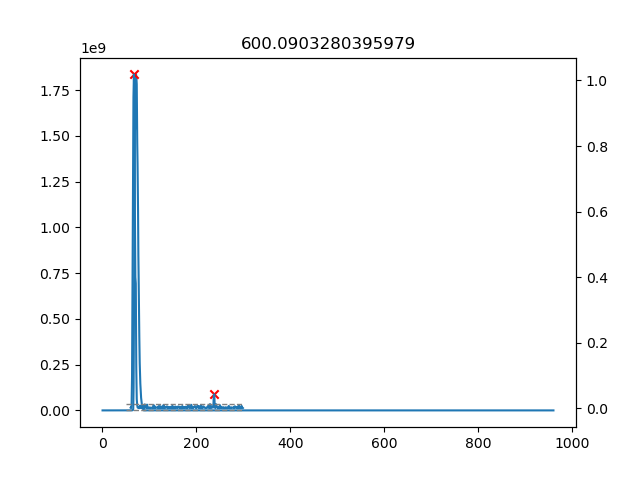

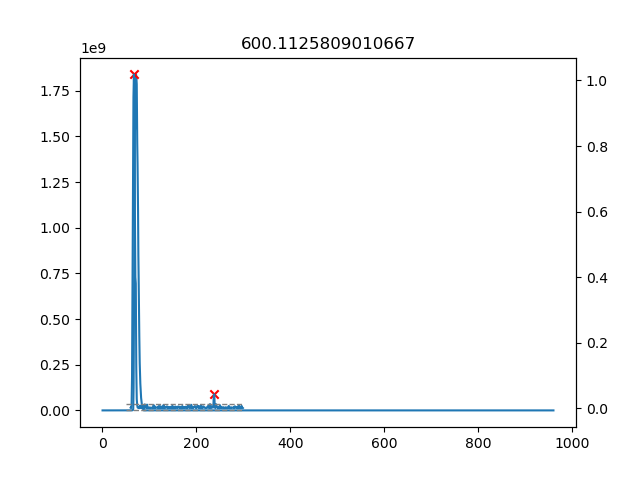

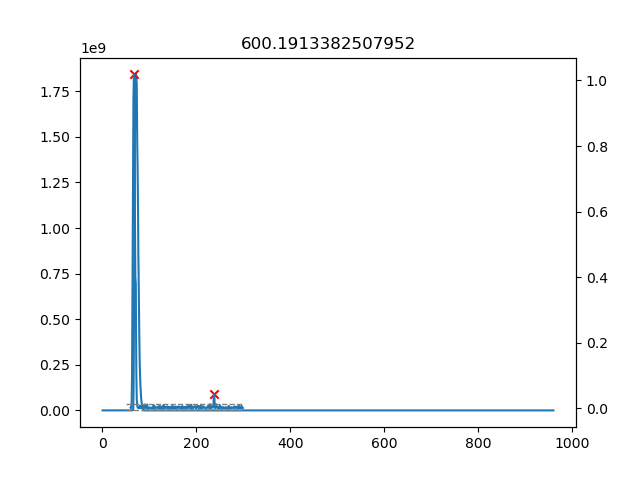

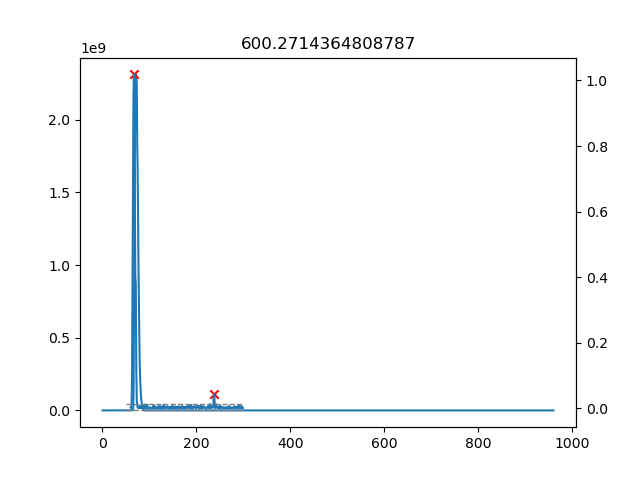

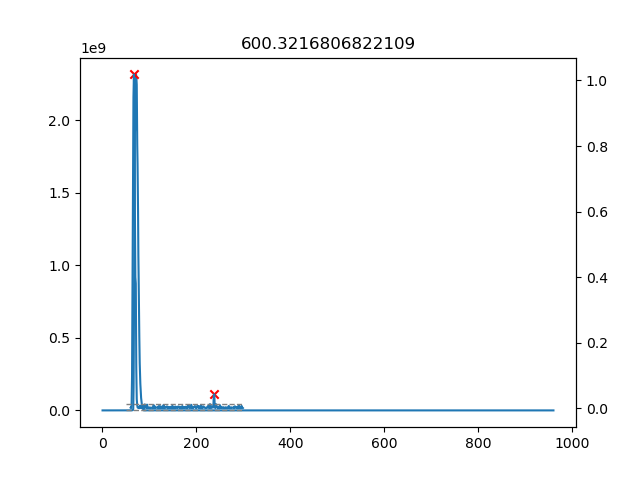

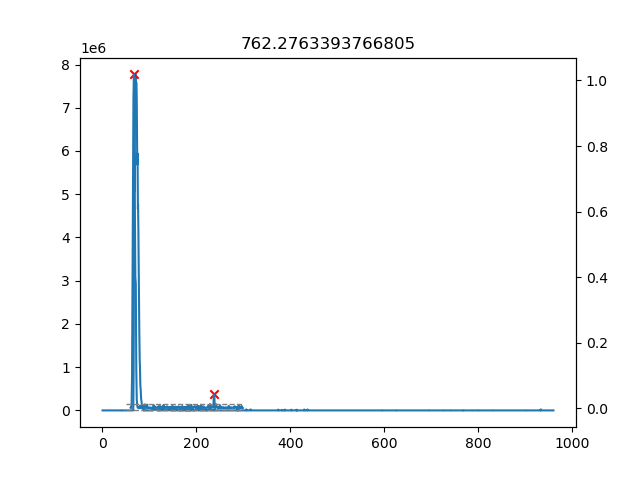

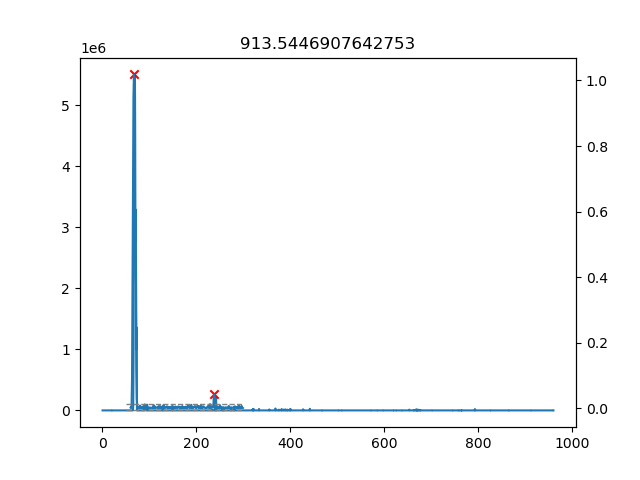

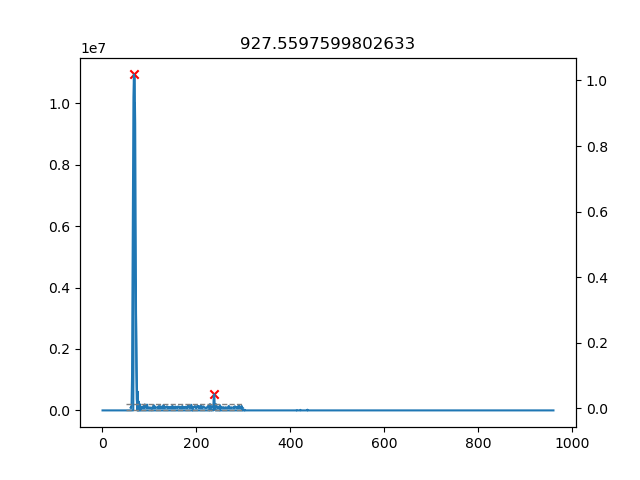

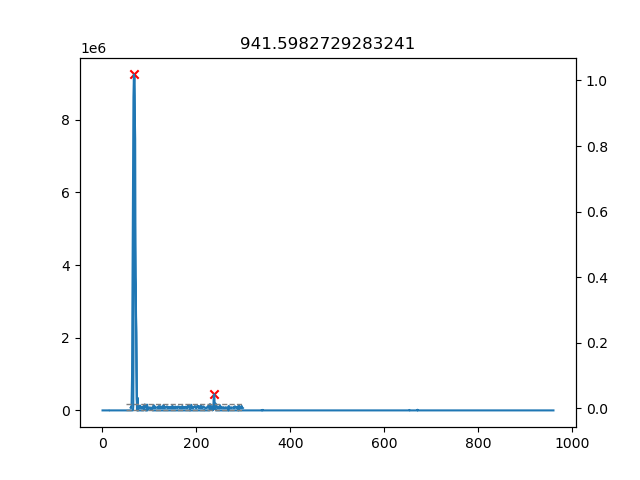

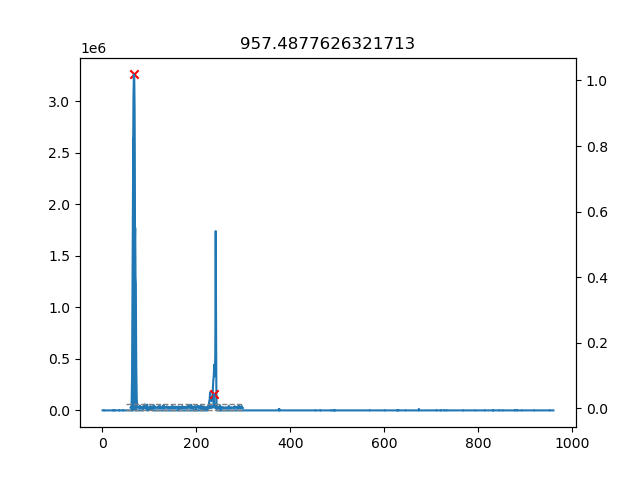

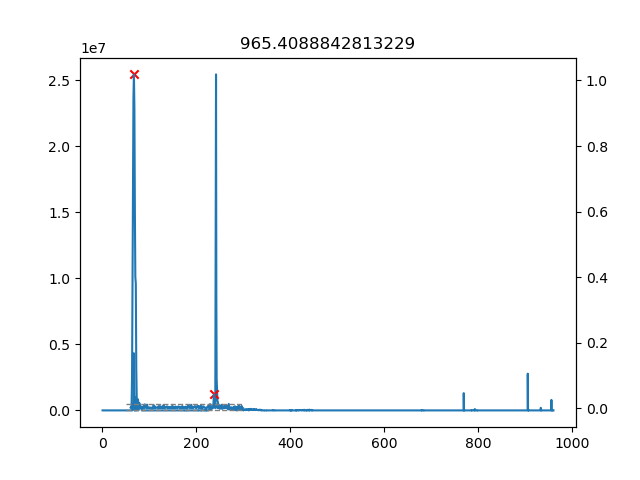

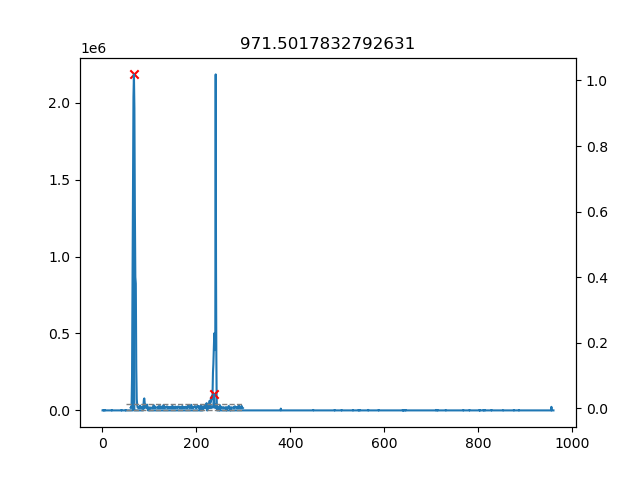

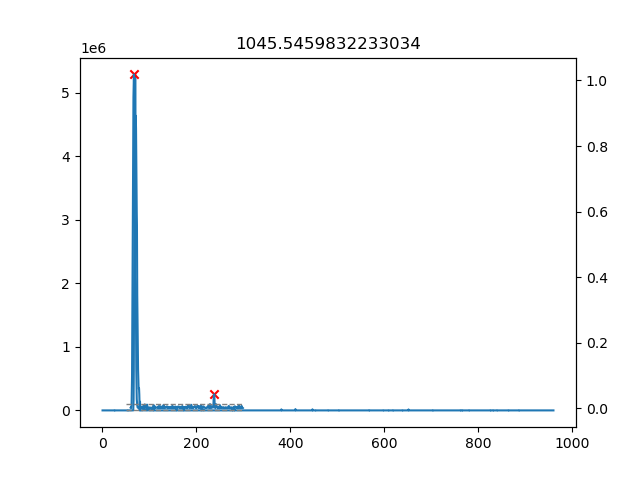

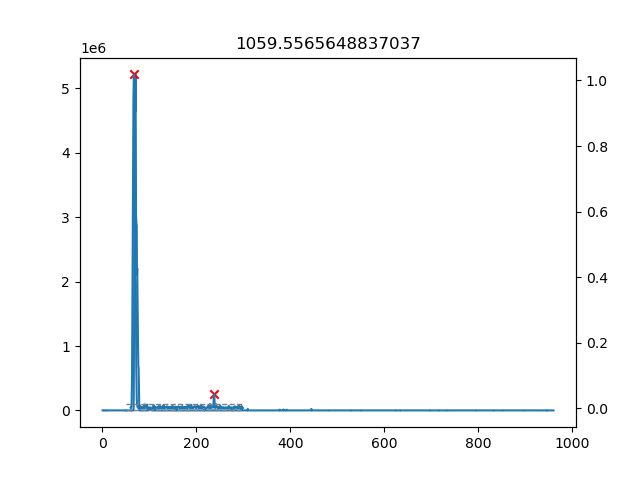

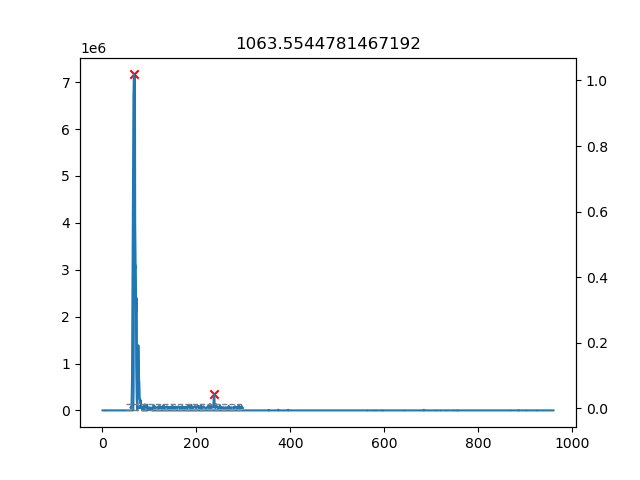

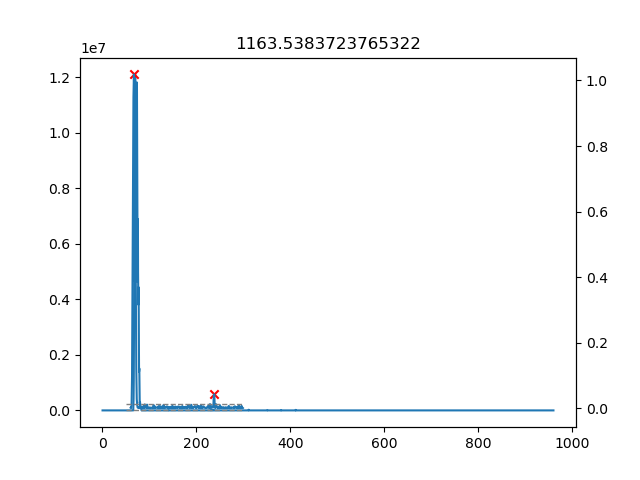

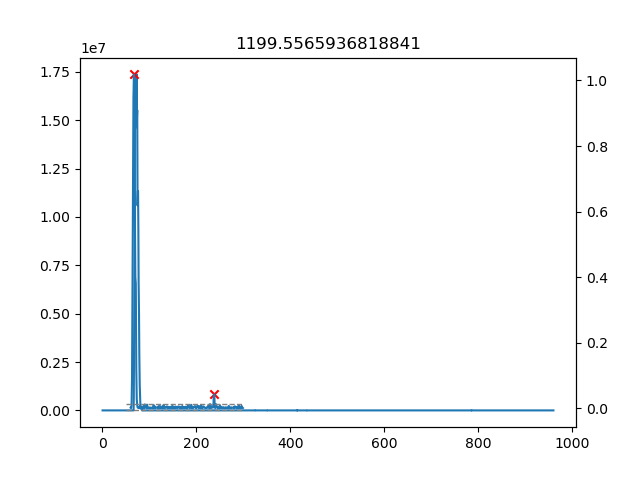

In [5]:
for mz in ft.loc[ft.activity>0,"mz"]:
    intsum_list=[]
    rtlist=[]
    for spec in exp:
        if spec.getMSLevel()==1:           
            mzval,i=spec.get_peaks()
            intsum=i[(mzval>mz-1) & (mzval<mz+1)].sum()
            rtlist.append(spec.getRT())
            intsum_list.append(intsum)

    fig,ax=plt.subplots()
    ax.plot(rtlist,intsum_list)
    ax.set(title=str(mz))
    
    # ax2=ax.twinx()
    # ax2.plot(at.RT,at.norm_intensity)
    # ax2.scatter(aft.RT,aft.norm_intensity,marker="x",c="red")
    # ax2.hlines([mn_old+3*std_old,mn_old-3*std_old],xmin=50,xmax=300,linewidth=1,colors="gray",ls="--")